In [ ]:
import sys 
import os
sys.path.append(os.path.abspath("/Users/mouginot/work/helpmetric"))
import cymetrichelper as cyh
import pandahelper as pdh


import cymetric as cym
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
from cymetric import graphs as cgr
from cymetric import timeseries as tm

%matplotlib inline

In [ ]:
from cymetric.tools import format_nucs, reduce, merge, add_missing_time_step
def SWU(evaler, facilities=()):
    """
    Shape the reduced SWU Data Frame. Applying nuclides/facilities selection when required.

    Parameters
    ----------
    evaler : evaler
    facilities :  of the facility
    nucs :  of nuclide to select.
    """

    # Get inventory table
    df = evaler.eval('TimeSeriesEnrichmentSWU')
    agents = evaler.eval('AgentEntry')

    rdc_table = []  # because we want to get rid of the nuclide asap
 
    if len(facilities) != 0:
        agents = agents[agents['Prototype'].isin(facilities)]
        rdc_table.append(['AgentId', agents['AgentId'].tolist()])

    df = reduce(df, rdc_table)

    base_col = ['SimId', 'AgentId']
    added_col = base_col + ['Prototype']
    df = merge(df, base_col, agents, added_col)

    df = df[['Time', 'Value']].groupby(['Time']).sum()
    df.reset_index(inplace=True)
    return df



In [ ]:
file = "cycle_div_a/main.sqlite"
db_ = cym.dbopen(file)
ev_ = cym.Evaluator(db=db_, write=False)


In [ ]:
cgr.flow_graph(evaler=ev_, label='com', stop=121)


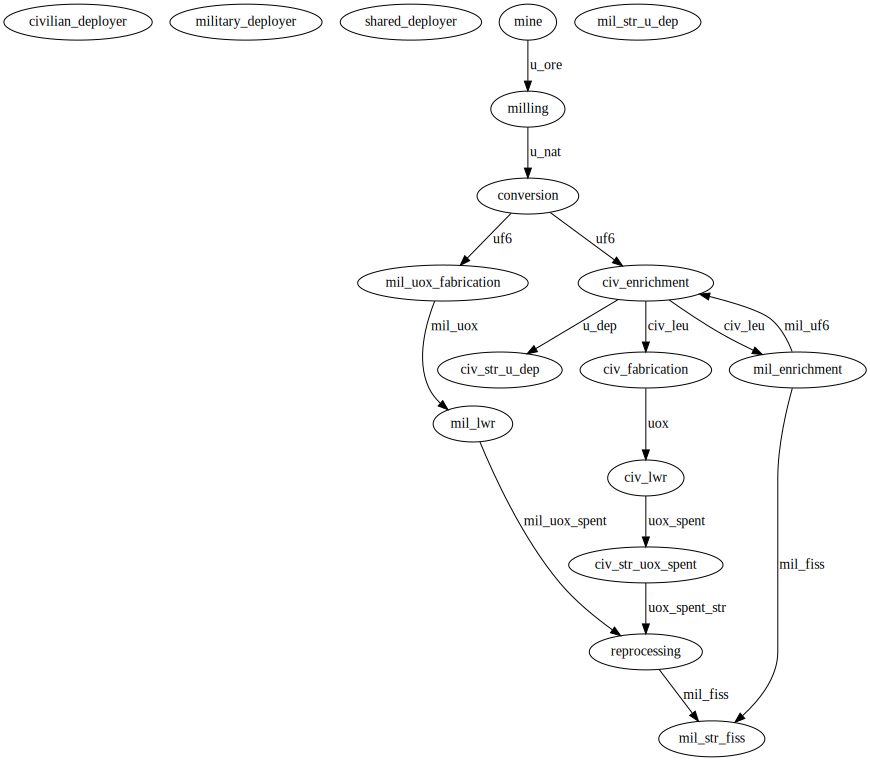

In [103]:
cgr.flow_graph(evaler=ev_, label='com', start=122)



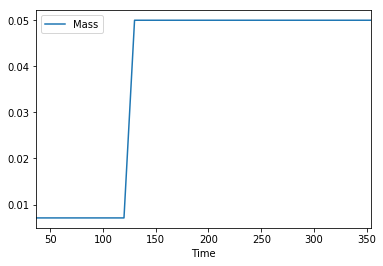

In [104]:
cyh.TransFrac(ev=ev_, rec=['mil_enrichment'], nucs2=['235U'], nucs1=['238U']).dropna().plot(x='Time', y='Mass')


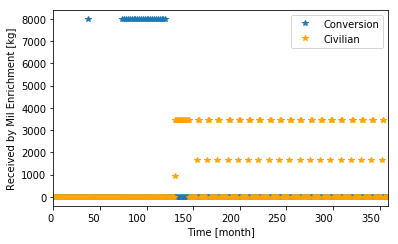

In [105]:
trans_mil_enrich_conversion = cyh.Trans(ev=ev_, send=['conversion'],rec=['mil_enrichment']).dropna()
trans_civ_enrich_mil = cyh.Trans(ev=ev_, send=['civ_enrichment'],rec=['mil_enrichment']).dropna()


ax = trans_mil_enrich_conversion.plot(subplots=True, x='Time', y='Mass', label='Conversion', style='*')
trans_civ_enrich_mil.plot(subplots=True, color='orange', x='Time', y='Mass', ax=ax, label='Civilian', style='*')
plt.ylabel('Received by Mil Enrichment [kg]')
plt.xlabel('Time [month]')

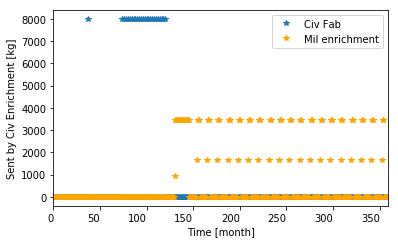

In [106]:
trans_civ_enrich_fab = cyh.Trans(ev=ev_, send=['civ_enrichment'],rec=['civ_fabrication']).dropna()
trans_civ_enrich_mil = cyh.Trans(ev=ev_, send=['civ_enrichment'],rec=['mil_enrichment']).dropna()

ax = trans_mil_enrich_conversion.plot(subplots=True, x='Time', y='Mass', label='Civ Fab', style='*')
trans_civ_enrich_mil.plot(subplots=True, color='orange', x='Time', y='Mass', ax=ax, label='Mil enrichment', style='*')
plt.ylabel('Sent by Civ Enrichment [kg]')
plt.xlabel('Time [month]')

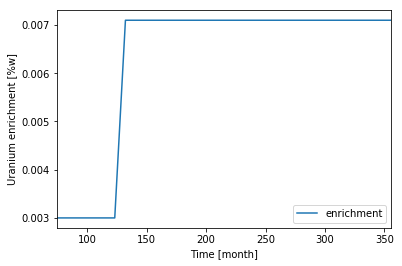

In [107]:
mil_feed_enrich = cyh.TransFrac(ev=ev_, send=['mil_enrichment'], rec=['mil_str_u_dep','civ_enrichment'], nucs2=['235U'], nucs1=['238U']).dropna()
mil_feed_enrich.plot(x='Time', y='Mass', label='enrichment')
plt.ylabel('Uranium enrichment [%w]')
plt.xlabel('Time [month]')

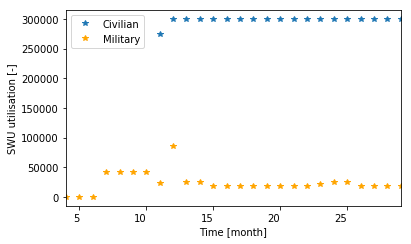

In [108]:
SWU_civ = SWU(ev_, facilities=['civ_enrichment'])
SWU_mil = SWU(ev_, facilities=['mil_enrichment'])
SWU_civ = SWU_civ[SWU_civ['Value']<1e50]

ax = cyh.month2year(SWU_civ, 1, 12, 'Value').plot(subplots=True, x='Time', y='Value', style='*', label='Civilian')

cyh.month2year(SWU_mil[SWU_mil['Value']<1e50], 1, 12, 'Value').plot(subplots=True, ax=ax, x='Time', y='Value', style='*', color='orange', label='Military')
plt.ylabel('SWU utilisation [-]')
plt.xlabel('Time [month]')

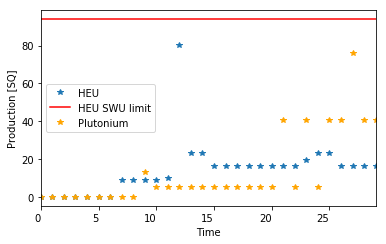

In [109]:
heu_prod = tm.transactions(ev_, senders = ['mil_enrichment'], receivers=['mil_str_fiss'])
heu_prod['Mass'] *= 1/25.
ax = cyh.month2year(heu_prod, 1, 12).plot(subplots=True, x='Time', y='Mass', style='*', label = 'HEU')
plt.axhline(y=196/25.*12., color='r', linestyle='-', label='HEU SWU limit')


pu_prod = tm.transactions(ev_, senders=['reprocessing'], receivers=['mil_str_fiss'])
pu_prod['Mass'] *= 1/8.
cyh.month2year(pu_prod, 1, 12).plot(subplots=True, color='orange', ax = ax, x='Time', y='Mass', style='*', label='Plutonium')

plt.ylabel('Production [SQ]')


In [110]:
heu_prod = tm.transactions(ev_, senders = ['mil_enrichment'], receivers=['mil_str_fiss'])
heu_prod[heu_prod['Mass']>0]


,Time,Mass
73,73,36.566332
75,75,36.566332
77,77,36.566332
79,79,36.566332
81,81,36.566332
83,83,36.566332
85,85,36.566332
87,87,36.566332
89,89,36.566332
91,91,36.566332


/Users/mouginot/.local/lib/python3.5/site-packages/cymetric/timeseries.py:205: UserWarning: no faciity provided
  warnings.warn(wng_msg, UserWarning)


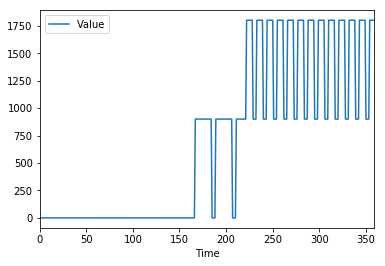

In [96]:
tm.get_power(ev_).plot(x='Time', y='Value')

In [97]:
file_b = "cycle_div_b/main.sqlite"
db_b = cym.dbopen(file_b)
ev_b = cym.Evaluator(db=db_b, write=False)



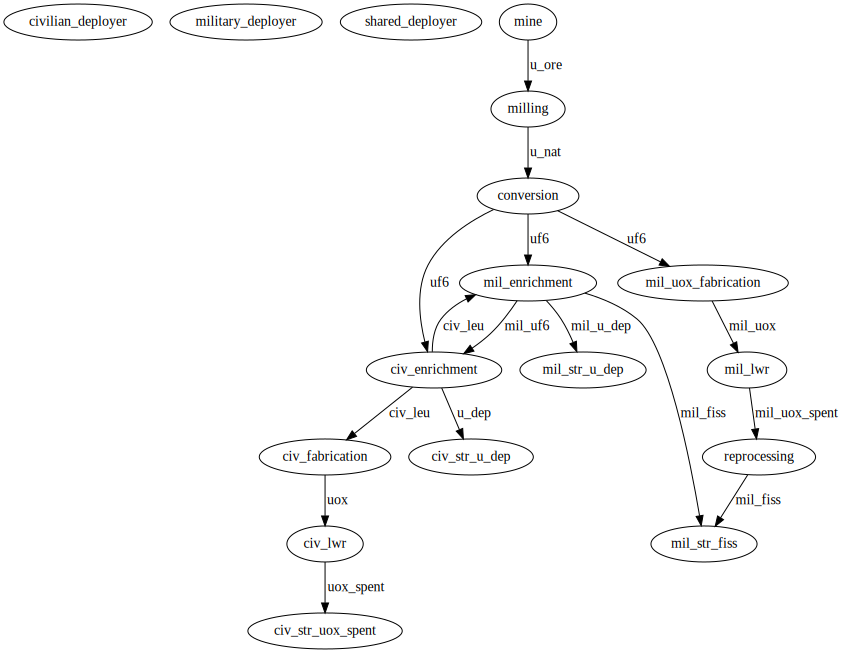

In [98]:
cgr.flow_graph(evaler=ev_b, label='com')



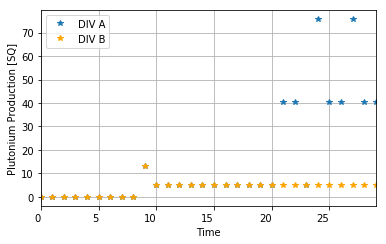

In [20]:

ax = cyh.month2year(pu_prod, 1, 12).plot(subplots=True, x='Time', y='Mass', style='*', label = 'DIV A')


pu_prod_b = tm.transactions(ev_b, senders=['reprocessing'], receivers=['mil_str_fiss'])
pu_prod_b['Mass'] *= 1/8.
cyh.month2year(pu_prod_b, 1, 12).plot(subplots=True, color='orange', ax = ax, x='Time', y='Mass', style='*', label='DIV B')

plt.ylabel('Plutonium Production [SQ]')
plt.grid()